# 测试学好的Q函数是否能表现得很好

实现目标：

1. 创建Agent， 并加载学习好的Q_net
2. 创建测试数据，使其可以分别输入IMM和Agent

In [1]:
from Agent import Agent
from Env import env

## 1. 加载Agent 

In [2]:
agent = Agent(T=5, cuda_id=1, test=True)
agent.load_Q_net("Q_net.model")

## 2.  数据生成

测试数据与训练数据同分布

In [14]:
from torch_geometric.data import Data
import torch
import numpy as np
import networkx as nx

In [44]:
# ER graph
n = 10000
p = np.log(n)/n
# p = 0.01
Env = env(graph_size=n, seed_size=n, p=p, weight=0.15)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

## 3. Simulation 

In [46]:
def simulation_once(edge_index, edge_w, seed_list):
    import networkx as nx
    import ndlib.models.ModelConfig as mc
    import ndlib.models.epidemics as ep
    
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    
    model = ep.IndependentCascadesModel(G)
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_initial_configuration("Infected", seed_list)
    
    # Setting the edge parameters
    for e, w in zip(G.edges(), edge_w):
        config.add_edge_configuration("threshold", e, w)
    
    model.set_initial_status(config)
    
    while True:
        iteration = model.iteration()
        if iteration["node_count"][1] == 0:
            break
    
    return iteration["node_count"][2]

In [47]:
def simulation(edge_index, edge_w, seed_list, mc=100):
    from tqdm import tqdm
    import numpy as np
    spreads = []
    for i in tqdm(range(mc)):
        spreads.append(simulation_once(edge_index, edge_w, seed_list))
        
    return np.mean(spreads)

## 3. 方法比较 

In [48]:
def Q_infer(agent, Env, graph, K):
    Seed = []
    for i in range(K):
        action = agent.choose_action(graph)
        Seed.append(action)
        graph.node_tag[action] = 1
        
    return Seed

In [64]:
def IMM_infer(edge_index, edge_w, K):
    import os
    import time
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    with open(".imm_cache/attribute.txt", "w") as f:
        f.writelines("n={}\nm={}".format(G.number_of_nodes(), G.number_of_edges()))
    with open(".imm_cache/graph_ic.inf", "w") as f:
        for edge, weight in zip(edge_index.T, edge_w):
            f.writelines("{} {} {:.3f}\n".format(edge[0], edge[1], weight))
    
    t0 = time.time()
    imm_red = os.popen("./IMM/imm_discrete -dataset .imm_cache/ -k {} -model IC -epsilon 0.1".format(K))
    # print("{:.1f}ms".format((time.time()-t0)*1000))
    
    Seed = []
    Spread = 0
    for line in imm_red:
        if "opt_lower_bound" in line:
            Spread = float(line.split("=")[1].strip())
        if "seedSet" in line:
            seed_set = line.split("=")[1].strip().split(" ")
            Seed = [int(s) for s in seed_set]
    
    return Seed, Spread

### 测试1， 相同大小的网络

In [81]:
import matplotlib.pyplot as plt

In [138]:
# ER graph
n = 1000
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=0.15)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))

100%|██████████| 500/500 [01:03<00:00,  7.94it/s]


577.502 572.72


100%|██████████| 500/500 [00:59<00:00,  8.42it/s]


605.02 603.212


100%|██████████| 500/500 [00:58<00:00,  8.55it/s]


623.126 614.778


100%|██████████| 500/500 [00:57<00:00,  8.77it/s]


642.326 624.114


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


655.078 631.086


100%|██████████| 500/500 [00:54<00:00,  9.09it/s]


666.036 639.638


100%|██████████| 500/500 [00:55<00:00,  8.99it/s]


677.452 653.258


100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


690.302 651.476


100%|██████████| 500/500 [00:54<00:00,  9.14it/s]


701.966 663.76


100%|██████████| 500/500 [00:54<00:00,  9.15it/s]

710.79 661.902


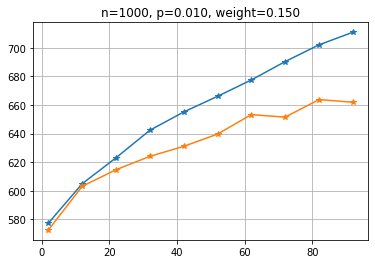

In [139]:
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

In [140]:
# ER graph
n = 500
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))

100%|██████████| 500/500 [00:10<00:00, 45.85it/s]


17.524 18.07


100%|██████████| 500/500 [00:12<00:00, 39.78it/s]


72.05 67.08


100%|██████████| 500/500 [00:13<00:00, 37.75it/s]


108.87 96.444


100%|██████████| 500/500 [00:12<00:00, 38.75it/s]


139.1 119.302


100%|██████████| 500/500 [00:13<00:00, 38.21it/s]


161.994 133.816


100%|██████████| 500/500 [00:12<00:00, 38.65it/s]


183.278 139.06


100%|██████████| 500/500 [00:13<00:00, 36.29it/s]


202.202 149.97


100%|██████████| 500/500 [00:13<00:00, 37.01it/s]


219.03 156.59


100%|██████████| 500/500 [00:13<00:00, 36.64it/s]


233.31 168.45


100%|██████████| 500/500 [00:14<00:00, 35.54it/s]

248.638 160.742


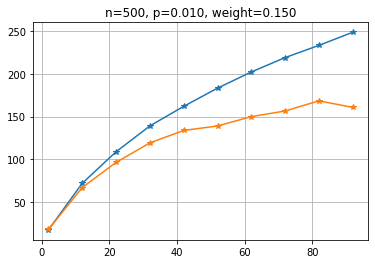

In [141]:
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:14<00:00, 34.87it/s]


35.24 35.66


100%|██████████| 500/500 [00:16<00:00, 30.11it/s]


111.36 104.58


100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


152.718 137.176


100%|██████████| 500/500 [00:17<00:00, 28.09it/s]


180.618 153.262


100%|██████████| 500/500 [00:16<00:00, 31.03it/s]


203.592 171.724


100%|██████████| 500/500 [00:16<00:00, 29.86it/s]


224.006 184.224


100%|██████████| 500/500 [00:16<00:00, 29.49it/s]


241.064 194.818


100%|██████████| 500/500 [00:16<00:00, 30.00it/s]


257.114 206.758


100%|██████████| 500/500 [00:16<00:00, 30.03it/s]


270.02 208.864


100%|██████████| 500/500 [00:16<00:00, 30.22it/s]


283.812 204.036


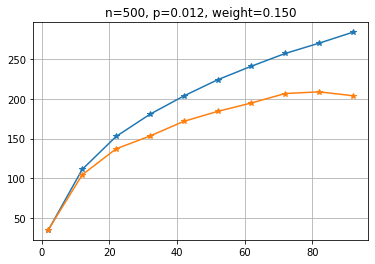

In [144]:
# ER graph
n = 500
p = np.log(n)/n
# p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(2, 101, 10)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

100%|██████████| 500/500 [00:13<00:00, 37.11it/s]


18.918 21.92


100%|██████████| 500/500 [00:15<00:00, 32.07it/s]


47.532 48.698


100%|██████████| 500/500 [00:15<00:00, 31.31it/s]


66.192 63.538


100%|██████████| 500/500 [00:16<00:00, 29.99it/s]


81.742 77.744


100%|██████████| 500/500 [00:16<00:00, 30.31it/s]


94.336 83.194


100%|██████████| 500/500 [00:16<00:00, 30.20it/s]


106.182 93.656


100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


117.144 96.112


100%|██████████| 500/500 [00:16<00:00, 30.24it/s]


125.494 100.562


100%|██████████| 500/500 [00:16<00:00, 29.51it/s]


129.906 109.224


100%|██████████| 500/500 [00:17<00:00, 29.28it/s]


139.736 116.506


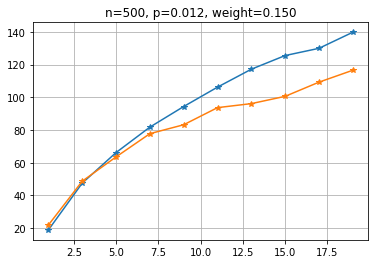

In [145]:
# ER graph
n = 500
p = np.log(n)/n
# p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(1, 21, 2)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()



100%|██████████| 500/500 [00:10<00:00, 48.89it/s]


7.782 7.746


100%|██████████| 500/500 [00:11<00:00, 44.93it/s]


20.988 18.458


100%|██████████| 500/500 [00:12<00:00, 40.82it/s]


33.018 33.128


100%|██████████| 500/500 [00:12<00:00, 39.85it/s]


43.142 39.44


100%|██████████| 500/500 [00:11<00:00, 42.60it/s]


55.056 43.218


100%|██████████| 500/500 [00:12<00:00, 39.42it/s]


61.786 52.84


100%|██████████| 500/500 [00:12<00:00, 41.19it/s]


71.604 55.986


100%|██████████| 500/500 [00:12<00:00, 40.42it/s]


78.492 58.056


100%|██████████| 500/500 [00:12<00:00, 40.17it/s]


85.972 65.932


100%|██████████| 500/500 [00:12<00:00, 39.63it/s]


93.358 71.348


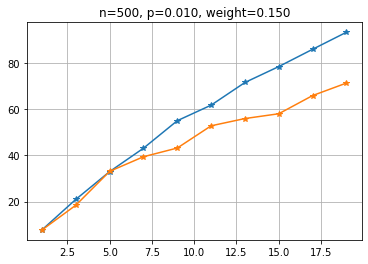

In [147]:
# ER graph
n = 500
# p = np.log(n)/n
p = 0.01
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(1, 21, 2)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()



100%|██████████| 500/500 [00:09<00:00, 51.65it/s]


92.65 91.67


100%|██████████| 500/500 [00:10<00:00, 49.81it/s]


116.404 115.864


100%|██████████| 500/500 [00:10<00:00, 49.74it/s]


120.772 119.8


100%|██████████| 500/500 [00:10<00:00, 48.79it/s]


125.954 122.9


100%|██████████| 500/500 [00:10<00:00, 48.98it/s]


129.094 125.754


100%|██████████| 500/500 [00:09<00:00, 52.93it/s]


132.132 125.246


100%|██████████| 500/500 [00:09<00:00, 51.69it/s]


134.054 128.554


100%|██████████| 500/500 [00:09<00:00, 52.46it/s]


137.386 128.724


100%|██████████| 500/500 [00:09<00:00, 51.52it/s]


140.832 130.784


100%|██████████| 500/500 [00:09<00:00, 50.41it/s]


142.726 130.14


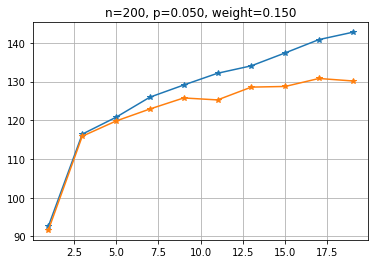

In [151]:
# ER graph
n = 200
# p = np.log(n)/n
p = 0.05
weight=0.15
Env = env(graph_size=n, seed_size=n, p=p, weight=weight)

mu, edge_index, edge_w, node_tag, done = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             mu = torch.Tensor(mu),
             edge_w = torch.Tensor(edge_w),
             node_tag = torch.Tensor(node_tag),
             num_nodes = n)

IMM_K = []
Q_K = []
K_range = range(1, 21, 2)
for K in K_range:
    imm_seed, imm_spread = IMM_infer(edge_index, edge_w, K=K)
    q_seed = Q_infer(agent, Env, graph, K=K)

    imm_simu = simulation(edge_index, edge_w, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_w, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.title("n={}, p={:.3f}, weight={:.3f}".format(n,p, weight))
plt.savefig("comparing_results/n_{}_p_{:.3f}_w_{:.3f}.pdf".format(n, p, weight))
plt.show()

